# Task 9

In [103]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
# Load the dataset
data = np.load('Data/circle_data_1.npy')

# Transpose data and populate
points = data.T
x_points = points[:, 0]
y_points = points[:, 1]

In [105]:
# Construct the A matrix and b vector for least-squares
N = len(points)
A = np.ones((N, 3))
b = np.zeros(N)

for i in range(N):
    x = x_points[i]
    y = y_points[i]
    A[i, 1] = -2 * x
    A[i, 2] = -2 * y
    b[i] = -(x**2 + y**2)

A

array([[ 1.        ,  3.4090711 , -3.47328761],
       [ 1.        ,  2.35568754, -0.52656519],
       [ 1.        ,  1.90098938, -3.35593188],
       [ 1.        ,  2.87709198,  0.09244163],
       [ 1.        ,  3.36759511, -1.2050373 ],
       [ 1.        ,  0.89709409, -2.63991226],
       [ 1.        ,  3.9227909 , -1.64759832],
       [ 1.        ,  3.02538767, -3.52739821],
       [ 1.        ,  0.38155817, -1.69987076],
       [ 1.        ,  0.21226918, -0.4064507 ],
       [ 1.        ,  1.68901941, -3.25482101],
       [ 1.        ,  0.34872947, -4.64367774],
       [ 1.        ,  4.50884682, -0.70654184],
       [ 1.        ,  2.02902995, -0.56832271],
       [ 1.        ,  2.72199301, -2.88228222],
       [ 1.        ,  0.85789716, -3.59870762],
       [ 1.        ,  0.39146927, -0.17144767],
       [ 1.        ,  3.58906069, -1.26331119],
       [ 1.        ,  0.68842332, -2.83901243],
       [ 1.        ,  0.29731161, -2.4221875 ],
       [ 1.        ,  1.41758816, -0.711

LS Center: (-1.0621100344153003, 0.9947560513264783)
LS Radius: 0.9788704078898127


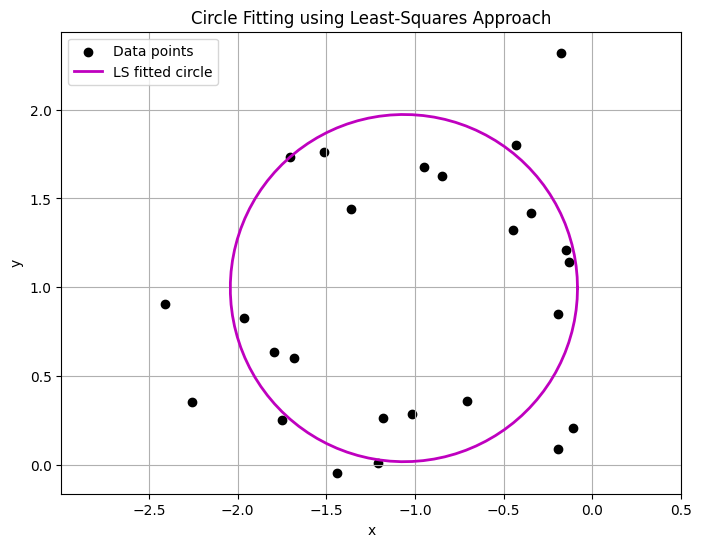

In [106]:
# Solve the least-squares problem
solution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

# Extract the solution
y_star = solution[0]
c_ls_x = solution[1]
c_ls_y = solution[2]
c_ls = np.array([c_ls_x, c_ls_y])

# Calculate the radius
R_ls = np.sqrt(np.linalg.norm(c_ls)**2 - y_star)

print(f"LS Center: ({c_ls_x}, {c_ls_y})")
print(f"LS Radius: {R_ls}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x_points, y_points, color='black', label='Data points')

# Plot the fitted circle
theta_plot = np.linspace(0, 2*np.pi, 100)
circle_x = c_ls_x + R_ls * np.cos(theta_plot)
circle_y = c_ls_y + R_ls * np.sin(theta_plot)
plt.plot(circle_x, circle_y, 'm-', linewidth=2, label='LS fitted circle')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Circle Fitting using Least-Squares Approach')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [107]:
# LEVENBERG-MARQUARDT ALGORITHM 
print("\n=== LEVENBERG-MARQUARDT ALGORITHM ===")

# Initialize parameters for LM
theta = np.array([c_ls_x, c_ls_y, R_ls])  # [c_x, c_y, R]
lambda_val = 1.0
epsilon = 1e-6
max_iter = 100

grad_norms = []
costs = []


=== LEVENBERG-MARQUARDT ALGORITHM ===


In [108]:
for iter in range(max_iter):
    # Compute residuals 
    r = np.zeros((N, 1))  
    for i in range(N):
        dist = np.linalg.norm(points[i] - theta[:2])
        r[i, 0] = dist - theta[2]  # Store as 2D array
    
    # Compute current cost
    current_cost = float(r.T @ r)  # Equivalent to f_p.T @ f_p
    costs.append(current_cost)
    
    # Compute Jacobian 
    J = np.zeros((N, 3))
    for i in range(N):
        dist = np.linalg.norm(points[i] - theta[:2])
        if dist > 1e-12:
            J[i, 0] = (theta[0] - points[i, 0]) / dist  # ∂r/∂c_x
            J[i, 1] = (theta[1] - points[i, 1]) / dist  # ∂r/∂c_y
        J[i, 2] = -1  # ∂r/∂R
    
    # Compute gradient (equivalent to total_grad_f)
    gradient = 2 * J.T @ r  # This is J^T @ r * 2
    grad_norm = np.linalg.norm(gradient)
    grad_norms.append(grad_norm)
    
    print(f"Iteration {iter+1}: Cost = {current_cost:.6f}, Grad Norm = {grad_norm:.6f}")
    
    # Check convergence
    if grad_norm < epsilon:
        print("Converged!")
        break
    
    # LM update step - using augmented system approach
    while True:
        # Build augmented system 
        sqrt_lambda = np.sqrt(lambda_val)
        A_aug = np.vstack([J, sqrt_lambda * np.eye(3)])  # [J; √λI]
        
        # Build b vector: [J@theta - r; √λ@theta]
        theta_vec = theta.reshape(3, 1)  # Convert to column vector
        b_aug = np.vstack([J @ theta_vec - r, sqrt_lambda * theta_vec])
        
        # Solve the augmented system
        theta_new_vec, *_ = np.linalg.lstsq(A_aug, b_aug, rcond=None)
        theta_new = theta_new_vec.flatten()  # Convert back to 1D array
        
        # Compute new cost
        new_r = np.zeros((N, 1))
        for i in range(N):
            dist = np.linalg.norm(points[i] - theta_new[:2])
            new_r[i, 0] = dist - theta_new[2]
        new_cost = float(new_r.T @ new_r)
        
        if new_cost < current_cost:
            # Accept update 
            theta = theta_new
            lambda_val = max(lambda_val * 0.7, 1e-12)
            break
        else:
            # Reject update 
            lambda_val = lambda_val * 2 
            if lambda_val > 1e12:
                print("Lambda too large, breaking")
                break

Iteration 1: Cost = 1.599213, Grad Norm = 1.898778
Iteration 2: Cost = 1.550781, Grad Norm = 0.100996
Iteration 3: Cost = 1.550585, Grad Norm = 0.006462
Iteration 4: Cost = 1.550584, Grad Norm = 0.000620
Iteration 5: Cost = 1.550584, Grad Norm = 0.000089
Iteration 6: Cost = 1.550584, Grad Norm = 0.000013
Iteration 7: Cost = 1.550584, Grad Norm = 0.000002
Iteration 8: Cost = 1.550584, Grad Norm = 0.000000
Converged!


/tmp/ipykernel_43867/164540508.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_cost = float(r.T @ r)  # Equivalent to f_p.T @ f_p
/tmp/ipykernel_43867/164540508.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_cost = float(new_r.T @ new_r)


In [109]:
# Extract LM results
c_lm_x, c_lm_y, R_lm = theta
print(f"\nLM Center: ({c_lm_x:.4f}, {c_lm_y:.4f})")
print(f"LM Radius: {R_lm:.4f}")


LM Center: (-1.0600, 0.9523)
LM Radius: 0.9443


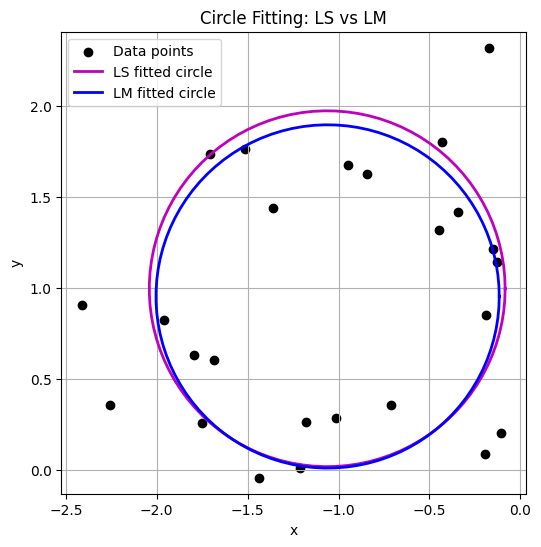

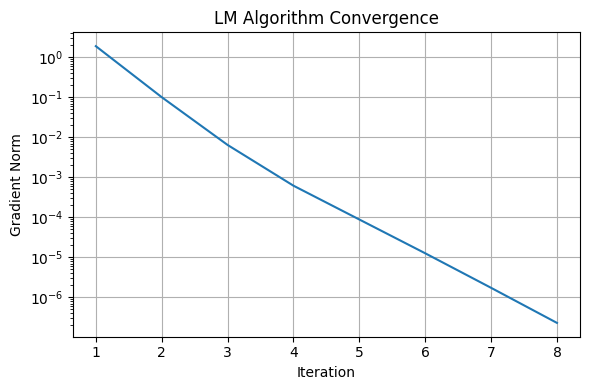

In [110]:
# Plot 1: Data with both circles
plt.figure(figsize=(6, 6))
plt.scatter(x_points, y_points, color='black', label='Data points')

# Plot LS circle
circle_ls_x = c_ls_x + R_ls * np.cos(theta_plot)
circle_ls_y = c_ls_y + R_ls * np.sin(theta_plot)
plt.plot(circle_ls_x, circle_ls_y, 'm-', linewidth=2, label='LS fitted circle')

# Plot LM circle
circle_lm_x = c_lm_x + R_lm * np.cos(theta_plot)
circle_lm_y = c_lm_y + R_lm * np.sin(theta_plot)
plt.plot(circle_lm_x, circle_lm_y, 'b-', linewidth=2, label='LM fitted circle')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Circle Fitting: LS vs LM')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Plot 2: Gradient norm across iterations
plt.figure(figsize=(6, 4))
plt.semilogy(range(1, len(grad_norms) + 1), grad_norms)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('LM Algorithm Convergence')
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [111]:
grad_norms

[np.float64(1.8987779605705692),
 np.float64(0.10099575389484595),
 np.float64(0.006462417725968754),
 np.float64(0.0006199580237478496),
 np.float64(8.864134388992835e-05),
 np.float64(1.2690976862920743e-05),
 np.float64(1.7393843561168594e-06),
 np.float64(2.3128178673363004e-07)]